# DUI Crashes and Arrests in San Diego

By Aaron Rothleder, Skyler Taylor, and Sarah George

Research Question
------------------
We want to look into DUI related car crashes and arrests in the San Diego area. 

How do the proportions of arrests compare to the proportions of crashes in San Diego? Furthermore, how are the number of alcohol permits in a given location correlated with the number of arrests and the number of DUI related crashes?

Hypothesis
---------
We hypothesize that San Diego will have roughly the same ratio of arrests and crashes, controlled for population.

Background Information
----

Analyzing DUI arrest and crash data is of interest because public safety is always a critical matter that should be monitored on a regular basis. Without strict monitoring of the improvement of DUI arrest rates over time, we cannot take action to improve the experience of San Diego citizens or tourists taking part in our city's night life. Background information included reports of arrest rates from prior years in the entire state (a DMV report that tracked changes in the arrest rate and alcohol related fatalities at https://www.dmv.ca.gov/portal/wcm/connect/77b8b0e3-c20b-42b0-8670-451d9c9262cd/S5-250.pdf?MOD=AJPERES) and articles about police officers setting up DUI checkpoints more often during holidays and other higher-risk times of year. 
    
The DMV report we read included statewide DUI arrest rates up until 2013, and noted significant decreases in rates from 2011-2012 and 2012-2013. We have also seen reports of DUI checkpoint locations at https://www.dmv.ca.gov/portal/wcm/connect/77b8b0e3-c20b-42b0-8670-451d9c9262cd/S5-250.pdf?MOD=AJPERES, and we would like to see if we could extend this downward trend in San Diego by identifying hotspots where crashes and accidents occur, that would be good locations for additional DUI checkpoints to prevent fatalities on the road.
    
    
Referencess:
- 1) https://www.dmv.ca.gov/portal/wcm/connect/ea06d0a4-a73f-4b2d-b6f1-257029275629/S5-246.pdf?MOD=AJPERES&CONVERT_TO=url&CACHEID=ea06d0a4-a73f-4b2d-b6f1-257029275629
- 2)https://www.dmv.ca.gov/portal/wcm/connect/77b8b0e3-c20b-42b0-8670-451d9c9262cd/S5-250.pdf?MOD=AJPERES

# Data Description

Dataset 1: Incidents-100k
- Link to the dataset: http://data.sandiegodata.org/de/dataset/clarinova_com-crime-incidents-casnd-7ba4-extract
- Number of observations: 100,000 
- Description: This data set shows all the police incidents in the San Diego area from 2007-2013. It conatins type of incident, date, and location. We will use this data to identify number of DUI arrests in the San Diego area.

Dataset 2: abs-license-casnd
- Link to the dataset: http://data.sandiegodata.org/de/dataset?organization=san-diego-regional-data-library&groups=crime&res_format%3Dhtml=
- Number of observations: 5,000
- Description: This data set shows all the places in the San Diego area that have permits to sell alcohol. It has location through address which will be used to get a Lon/Lat coordinate. It also has expiration dates so we would filter for permits that are valid in the year we are studying. This data can be used to find hot spots of alcohol consumption in the San Diego.

Dataset 3: pd_collisions_datasd
- Link to the dataset: https://data.sandiego.gov/datasets/police-collisions/
- Number of observations: 25,000
- Description: This data contains information on all the collisions in the San Diego area in 2015-2017. It contains location street number and name. We will use this to get long/lat information. It also has charge description data which shows if a DUI was involved in the crash. This data will be used to get number of crashes due to DUI for a certain area.

Dataset 4: ARJIS_PublicCrime060717
- Link to the dataset: http://www.sandag.org/index.asp?classid=14&subclassid=21&projectid=446&fuseaction=projects.detail
- Number of observations: 59,000
- Description: This dataset contains the last 180 days of public crime incidents in San Diego. It contains the past 180 days of crime data until our download date on June 7th, 2017. This includes a block address where the incident occurred, a charge description, activity date, the arresting party, zip code, and neighborhood.
- This data will be filtered down to only DUI related crime incidents and will be used to find specific locations through geocoding the street addresses where DUI arrests occur.

Dataset 5: Zip_Coords
- Link to the dataset: http://federalgovernmentzipcodes.us/
- Number of observations: 150
- Description: A csv of zip codes and their corresponding latitude and longitude coordinates filtered down from a comprehensive list of zip codes and their coordinates in the US. 
- This data will be used to mark population densities in our grid representing San Diego, so that we can control for population when calculating crash and arrest rates.

Dataset 6: ZipCode_Populations
- Link to the dataset: https://catalog.data.gov/dataset/zip-code-data
- Number of observations: 861
- Description: A list of San Diego zip codes with demographic information that separates population counts for each zip by race. We will have to sum over all races to get a sum for each zip that we will then use together with the Zip_Coords file to create population densities on our latitude/longitude grid.

# Data Cleaning and Preprocessing

In [2]:
# Import pandas, numpy, matplotlib
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from pygeocoder import Geocoder
from geopy.geocoders import Nominatim
from geopy.distance import vincenty
import moment

# Cleaning DUI Arrests Data (2007-2013)

The datafile 'incidents-100k.csv'shows all the police incidents in the San Diego area from 2007-2013. It conatins type of incident, date, and location. We will use this data to identify number of DUI arrests in the San Diego area.

link:
http://data.sandiegodata.org/de/dataset/clarinova_com-crime-incidents-casnd-7ba4-extract

In [3]:
# Pull the comprehensive police reported incidents file, dated from 2007 to 2013.
incidents_180 = pd.read_csv('arrests_180_days.csv')
incidents_180.dropna(inplace=True)
incidents_180.head(5)

,agency,Charge_Description_Orig,activityDate,BLOCK_ADDRESS,ZipCode,community
0,SHERIFF,290 VIOLATION AFTER INCARCERATION (F),2/13/17 17:00,9400 BLOCK CHESAPEAKE DRIVE,92123.0,SAN DIEGO
1,SHERIFF,290 VIOLATION AFTER INCARCERATION (F),1/2/17 17:00,9600 BLOCK CHESAPEAKE DRIVE,92123.0,SAN DIEGO
2,SHERIFF,290 VIOLATION AFTER INCARCERATION (F),12/9/16 17:00,9600 BLOCK CHESAPEAKE DRIVE,92123.0,SAN DIEGO
3,SHERIFF,290 VIOLATION AFTER INCARCERATION (F),12/14/16 17:00,0 BLOCK UNKNOWN,92020.0,EL CAJON
4,SHERIFF,290 VIOLATION AFTER INCARCERATION (F),3/28/17 17:00,9400 BLOCK CHESAPEAKE DRIVE,92123.0,SAN DIEGO


In [4]:
# Filter dataframe down to info on just DUI incidents
dui_incidents_180 = incidents_180[incidents_180['Charge_Description_Orig'].str.contains("DUI")]
dui_incidents_180.head(5)


,agency,Charge_Description_Orig,activityDate,BLOCK_ADDRESS,ZipCode,community
15932,EL CAJON,DRIVING UNDER INFLUENCE WITHIN 10 YEARS OF PRI...,5/12/17 1:39,700 S BLOCK MAGNOLIA AVENUE,92020.0,EL CAJON
15933,CHULA VISTA,DRIVING UNDER INFLUENCE WITHIN 10 YEARS OF PRI...,3/10/17 0:09,EVANS AVENUE / E L STREET,91911.0,CHULA VISTA
15935,SHERIFF,DRIVING UNDER INFLUENCE WITHIN 10 YEARS OF PRI...,2/3/17 22:25,400 BLOCK ALMOND ROAD,92078.0,SAN MARCOS
18415,EL CAJON,DUI .08 ALC:CAUSING BODILY INJ (F),3/24/17 20:20,N 03RD STREET / E MAIN STREET,92020.0,EL CAJON
18416,OCEANSIDE,DUI .08 ALC:CAUSING BODILY INJ (F),12/22/16 21:28,4000 BLOCK VISTA WAY,92056.0,OCEANSIDE


Geocoding
----
First, we will need to geocode the addresses of our DUI incidents (arrest data) and our DUI crash data to extract latitude and longitude coordinates from street addresses. Please note that we have not executed the cell below since we will reach the geocode query limit if we do, but we have written the results to file from a previous run-through.

In [5]:
#Next we should use geocoding to get lon/lat of the addresses
# First, geocode the 'address' column of our DUI Crash file and save in a series called 's'.
# We will then convert this series to a dataframe and write to a file called 
# 'coordinate_crashes.csv'

"""for i in range(0, len(dui_crashes15_17)): 
    while(True):
        try:
            x,y = Geocoder.geocode(dui_crashes15_17.iloc[i]['address']).coordinates
            s[i] = (x,y)
        except:
            time.sleep(5)
            continue
        break
        
# Similarly, geocode the 'Block Addresses' in the DUI Arrests file and write to csv.
# The coordinate data will then be available in the file 'dui_incidents_180.csv'

for i in range(0,len(dui_incidents_180)):
    while(True):
        try:
            x,y = Geocoder.geocode(dui_incidents_180.iloc[i]['BLOCK_ADDRESS']).coordinates
            s1[i] = (x,y)
            s1.to_csv("dui_incidents_180.csv")
        except:
            time.sleep(5)
            continue
        break
"""

# Write the coordinates of our crash data to one file, and the coordinates of our
# dui incidents to another.
"""
Save new dataframe in file "coordinate_crashes.csv"
dui_crashes15_17['coordinates'] = s.to_frame()
new_crashes.to_csv('coordinate_crashes.csv', sep=',')
crashes = pd.read_csv('coordinate_crashes.csv')
dui_incidents_180['coordinates'] = s1.to_frame()
dui_incidents_180['coordinates'].to_csv("dui_incidents_180.csv",sep=',')
"""


'\nSave new dataframe in file "coordinate_crashes.csv"\ndui_crashes15_17[\'coordinates\'] = s.to_frame()\nnew_crashes.to_csv(\'coordinate_crashes.csv\', sep=\',\')\ncrashes = pd.read_csv(\'coordinate_crashes.csv\')\ndui_incidents_180[\'coordinates\'] = s1.to_frame()\ndui_incidents_180[\'coordinates\'].to_csv("dui_incidents_180.csv",sep=\',\')\n'

In [6]:
# Read in our zip code csv with population counts
zip_code_df = pd.read_csv('ZipCode_Populations.csv')
zip_code_df.head(5)

,Zip,YEAR,RACE,NUMBER
0,91901,2010,Pacific Islander,43
1,91901,2010,White,13131
2,91901,2010,Black,201
3,91901,2010,Other,9
4,91901,2010,Two or More,375


In [7]:
# Since our population counts are separated by race, lets sum over unique zip codes and 
# accumulate a summed population for each zip.

In [8]:
curr_zip = zip_code_df['Zip'][0]

sums = {}
temp_sum = 0

for i in range(0,len(zip_code_df)):    
    if curr_zip != zip_code_df.iloc[i]['Zip']:
        sums[curr_zip] = temp_sum
        curr_zip = zip_code_df.iloc[i]['Zip']
        temp_sum = zip_code_df.iloc[i]['NUMBER']
    else:
        temp_sum += zip_code_df.iloc[i]['NUMBER']

In [9]:
print(sums)

{91901: 17084, 91902: 17005, 91905: 1669, 91906: 5765, 91910: 76153, 91911: 83249, 91913: 40346, 91914: 15627, 91915: 25126, 91916: 2006, 91917: 2276, 91931: 350, 91932: 26325, 91934: 775, 91935: 8235, 91941: 33302, 91942: 36886, 91945: 25320, 91948: 340, 91950: 55312, 91962: 1698, 91963: 1162, 91977: 59164, 91978: 7956, 91980: 173, 92003: 4354, 92004: 4054, 92007: 10531, 92008: 27568, 92009: 39735, 92010: 14481, 92011: 22393, 92014: 13432, 92019: 42637, 92020: 58407, 92021: 65227, 92024: 52579, 92025: 48275, 92026: 52417, 92027: 53143, 92028: 46449, 92029: 18624, 92036: 3573, 92037: 38652, 92040: 40286, 92054: 37941, 92055: 33412, 92056: 51590, 92057: 54152, 92058: 23406, 92059: 1498, 92060: 778, 92061: 2855, 92064: 47904, 92065: 35365, 92066: 430, 92067: 8689, 92069: 46322, 92070: 697, 92071: 53211, 92075: 11854, 92078: 39983, 92081: 27422, 92082: 17896, 92083: 37082, 92084: 47861, 92086: 1131, 92091: 1621, 92093: 8718, 92096: 622, 92101: 35623, 92102: 42967, 92103: 30680, 92104: 449

In [10]:
# Read in our zip code csv that contains latitude and longitude coordinates. We want to link
# this information to our other zip code data with population counts.

df_zip_coords = pd.read_csv('Zip_Coords.csv')

# Drop unnecessary columns from data, such as Status, City, and State, since we already 
# know our zip code values are San Diego specific.
df_zip_coords.drop(['Idk', 'City', 'State', 'Status'], axis=1, inplace=True)
df_zip_coords.head(10)

,Zip Code,Lat,Lon
0,92101,32.71,-117.16
1,92102,32.72,-117.09
2,92103,32.74,-117.17
3,92104,32.73,-117.12
4,92105,32.73,-117.08
5,92106,32.72,-117.23
6,92107,32.73,-117.24
7,92107,32.73,-117.24
8,92108,32.77,-117.10
9,92109,32.79,-117.23


In [11]:
# Convert our zip codes to string so that we can compare them to the xip codes in our
# population dataframe.
for i in range(0, len(df_zip_coords)):
    df_zip_coords.iloc[i]['Zip Code'] = str(df_zip_coords.iloc[i]['Zip Code'])

df_zip_coords.head(10)

/Users/sarahgeorge/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Zip Code,Lat,Lon
0,92101,32.71,-117.16
1,92102,32.72,-117.09
2,92103,32.74,-117.17
3,92104,32.73,-117.12
4,92105,32.73,-117.08
5,92106,32.72,-117.23
6,92107,32.73,-117.24
7,92107,32.73,-117.24
8,92108,32.77,-117.10
9,92109,32.79,-117.23


In [12]:
# Convert our summed population counts to string
for i in sums:
    sums[i] = str(sums[i])
    
# Create a dataframe from our dictionary of population sums called 'df_zip_pops'.
df_zip_pops = pd.DataFrame.from_dict(sums, orient='index').reset_index()
df_zip_pops.rename(columns = {'index':'Zip Code', 0:'Population'}, inplace=True)

In [13]:
# Let's look at our new dataframe.
print("Length: ", len(df_zip_pops))
df_zip_pops.head(10)


Length:  110


,Zip Code,Population
0,91901,17084
1,91902,17005
2,91905,1669
3,91906,5765
4,91910,76153
5,91911,83249
6,91913,40346
7,91914,15627
8,91915,25126
9,91916,2006


In [14]:
# Merge our first dataset with zipcode coordinates with our second dataset with zipcode
# populations.
merged_zips = pd.merge(df_zip_coords, df_zip_pops, on='Zip Code')
merged_zips = merged_zips.drop_duplicates()
print("Length: ", len(merged_zips))

# Fix any odd indexing that occurs after dropping rows
merged_zips = merged_zips.reset_index(drop=True)

Length:  39


In [15]:
# Let's deal with population.
# Create a column in our dataframe with a 'distributed population', that divides our 
# summed count by a set radius value, r^2. 
# *Note* this is assuming evenly distributed population in a zip code area


# Initialize a series called 'distributed_pop'
distributed_pop = pd.Series()

# Add to dataframe
merged_zips['distributed_pop'] = distributed_pop
merged_zips.head(5)

# Set radius value
radius = 2

for i in range(0, len(merged_zips)):
    merged_zips.set_value(i, 'distributed_pop', 
                          str(((int(merged_zips.iloc[i]['Population']))/(radius*radius))))

# Only need the coordinate values and distributed population in final dataframe for analysis
merged_zips = merged_zips[['Lat','Lon','distributed_pop']]
merged_zips.head(5)

,Lat,Lon,distributed_pop
0,32.71,-117.16,8905.75
1,32.72,-117.09,10741.75
2,32.74,-117.17,7670.00
3,32.73,-117.12,11236.75
4,32.73,-117.08,17567.50


# Now lets put all of our data into a matrix of lists.
We are going to make a matrix based off of coordinates ranges in our map. Each square in the map with contains a list of 4 items: 

crashes -  number of DUI related crashes in the area

arrests - number of DUI related arrests in the area

licenses - number of alcohol licenses in the area

population - population size in the area

In [16]:
# Initialize boundary values for our grid that will model a slice of San Diego.

min_lat = 32.54
max_lat = 33.05
min_lon = -117.25
max_lon = -116.95

#number of matrix columns and rows
matrix_dim = 10

#make matrix
matrix = [[0 for j in range(matrix_dim)] for i in range(matrix_dim)]

#width of a cell
cell_width = abs((max_lat - min_lat)/matrix_dim)

#height of a cell
cell_height = (max_lon - min_lon)/matrix_dim

print("Matrix will be of dimension " + str(matrix_dim) + "x" + str(matrix_dim) + '\n')
print("Cell width: " + str(cell_width) + " latitude points")
print("Cell height: " + str(cell_height) + " longitude points" + '\n')

print(matrix)

Matrix will be of dimension 10x10

Cell width: 0.0509999999999998 latitude points
Cell height: 0.029999999999999714 longitude points

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


In [17]:
# Read in our geocoded data for crashes.
crash_data = pd.read_csv('crash_coordinates.csv')
crash_data.head(5)

,0,"(30.0206764, -90.10265509999999)"
0,1,"(32.9178621, -117.1426708)"
1,2,"(41.4580185, -96.4925694)"
2,3,"(38.9062481, -90.13781209999999)"
3,4,"(36.077923, -102.519732)"
4,5,"(32.6972057, -117.032704)"


In [18]:
# ARREST ARRAY
arrest_data = pd.read_csv('dui_incidents_180.csv')
arrest_data = arrest_data['coordinates']

arrest_coords_arr = np.zeros(len(arrest_data), dtype=('2float'))
coord = []
# Organize arrest coordinates 
for i in range(0,len(arrest_data)-1):
    coord = arrest_data.iloc[i]
    opening_paren_index = coord.find("(")
    comma_index = coord.find(",")
    closing_parn_index = coord.find(")")
    arrest_lat = float(coord[opening_paren_index+1:comma_index])
    arrest_lng = float(coord[comma_index+2:closing_parn_index])
    arrest_coords_arr[i] = ((arrest_lat,arrest_lng))

In [19]:
# CRASH ARRAY
crash_coords_df = pd.read_csv('crash_coordinates.csv')

crash_coords_arr = np.zeros(len(df_zip_coords), dtype=('2float'))
for i in range(0,len(crash_coords_arr)-1):
    coord = crash_coords_df.iloc[i]
    opening_paren_index = coord[1].find("(")
    comma_index = coord[1].find(",")
    closing_parn_index = coord[1].find(")")
    crash_lat = float(coord[1][opening_paren_index+1:comma_index])
    crash_lng = float(coord[1][comma_index+2:closing_parn_index])
    crash_coords_arr[i] = ((crash_lat,crash_lng))



Cleaning Alcohol Permit Data
---

In [20]:
# ALCOHOL PERMIT ARRAY
alc_permits = pd.read_csv('abs-licenses-casnd.csv')
crash_coordinates_s = pd.read_csv("crash_coordinates.csv")
crash_coordinates_s.head(5)

# Reduce to pertinent data columns
alc_permits = alc_permits[['last_date', 'status', 'issuedate', 'exprdate', 'lon', 'lat', 'business']]
# Filter out data that may be outside the San Diego area.
# Limit range so that any outliers or typos in data are eliminated

alc_permits = alc_permits.drop(alc_permits[alc_permits['lon'] < -120].index)
alc_permits.dropna(inplace = True)
#Alcohol Permits SCATTER PLOTTING

permit_coords = np.zeros(len(alc_permits), dtype=('2float'))

# Collect an array of permit coordinates into 'permit_coords'
for i in range(0, len(alc_permits)):
    alc_lat = float(alc_permits['lat'].iloc[i])
    alc_lng = float(alc_permits['lon'].iloc[i])
    permit_coords[i] = (alc_lat, alc_lng)

Modeling the Data as a Grid
-------
We will now gather all of our four data categories into a comprehensive matrix. Our leftmost grid square corresponds to our leftmost latitude boundary coordinate of our data while our rightmost grid square corresponds to our highest latitude boundary coordinate of our data.
Similary, the top row of grid cells are the lowest longitude and the bottom row are the highest longitude coordinates.

Each matrix cell is a list. List entry 1 is the number of crashes in that square, list entry 2 is the number of arrests, list entry 3 is the number of alcohol permits, and list entry 4 is an estimate for the population in that square of the matrix based on surrounding zip codes.

In [21]:
# Input data into matrix lists

for i in range(matrix_dim):
    for j in range(matrix_dim):
        # Initialize array to count instances that a coordinate meets boundary conditions
        in_list=[]
        crash_array=[]
        arrest_array=[]
        permit_array=[]
        pop_array=[]
        #print(float(merged_zips.loc[0][1]))
        for k in range(len(crash_coords_arr)):
            crash_bool = ((crash_coords_arr[k][0] >= min_lat + cell_width*i) 
                             and (crash_coords_arr[k][0] <= min_lat + cell_width*(i+1))
                             and (crash_coords_arr[k][1] >= min_lon + cell_height*j) 
                             and (crash_coords_arr[k][1] <= min_lon + cell_height*(j+1)))
            if crash_bool == True:
                crash_array.append(1)
        for k in range(len(arrest_coords_arr)):
            arrest_bool = ((arrest_coords_arr[k][0] >= min_lat + cell_width*i) 
                             and (arrest_coords_arr[k][0] <= min_lat + cell_width*(i+1))
                             and (arrest_coords_arr[k][1] >= min_lon + cell_height*j) 
                             and (arrest_coords_arr[k][1] <= min_lon + cell_height*(j+1)))
            if arrest_bool == True:
                arrest_array.append(1)
        for k in range(len(permit_coords)):
            permit_bool = ((permit_coords[k][0] >= min_lat + cell_width*i) 
                             and (permit_coords[k][0] <= min_lat + cell_width*(i+1))
                             and (permit_coords[k][1] >= min_lon + cell_height*j) 
                             and (permit_coords[k][1] <= min_lon + cell_height*(j+1)))
            if permit_bool == True:
                permit_array.append(1)
        for k in range(len(merged_zips)):
            pop_bool = ((float(merged_zips.loc[k][0]) >= min_lat + cell_width*i) 
                             and (float(merged_zips.loc[k][0]) <= min_lat + cell_width*(i+1))
                             and (float(merged_zips.loc[k][1]) >= min_lon + cell_height*j) 
                             and (float(merged_zips.loc[k][1]) <= min_lon + cell_height*(j+1)))
            if pop_bool == True:
                pop_array.append(merged_zips.loc[k][2])
        ###############################
        # How we organized our 4 data points:
        # list[0] = # of crashes
        # list[1] = # of arrests
        # list[2] = # of permits
        # list[3] = # of people
        ###########################
        in_list.append(len(crash_array))
        in_list.append(len(arrest_array))
        in_list.append(len(permit_array))
        in_list.append(sum(pop_array))
        matrix[j][i] = in_list
print(matrix)

### NOTE: Sum for population count

[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [1, 4, 85, 12194.0], [6, 38, 58, 11450.5], [1, 24, 60, 0], [0, 2, 11, 0], [1, 3, 23, 0], [0, 0, 120, 0], [0, 0, 8, 0]], [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 46, 858.75], [2, 10, 139, 0], [3, 32, 36, 12654.25], [2, 8, 56, 10845.5], [0, 0, 16, 1063.25], [0, 1, 4, 12429.0], [0, 0, 0, 0]], [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 41, 283.75], [0, 1, 183, 19064.5], [5, 5, 86, 5963.0], [0, 13, 55, 24621.75], [0, 0, 13, 0], [0, 0, 16, 0], [1, 1, 2, 12429.0], [0, 0, 0, 0]], [[0, 0, 8, 0], [0, 0, 1, 0], [0, 0, 0, 4544.0], [1, 8, 153, 8944.5], [6, 17, 152, 0], [1, 12, 130, 18553.25], [0, 0, 11, 18259.75], [3, 3, 21, 0], [0, 1, 2, 0], [0, 1, 0, 0]], [[0, 0, 12, 0], [0, 0, 5, 0], [0, 2, 23, 15689.75], [0, 3, 72, 11236.75], [1, 21, 129, 12407.5], [0, 2, 30, 6585.75], [0, 0, 11, 18259.25], [1, 4, 36, 0], [0, 4, 19, 12802.0], [0, 0, 18, 9818.0]], [[0, 0, 13, 0], [0, 0, 82, 0], [0, 0, 112, 0], [5, 6, 29, 28309.25], [3, 18, 89, 4547.75], [1, 2, 8, 758

In [32]:
print("Candidate 1: ",matrix[3][5])
print("Candidate 2: ", matrix[3][4])
print("Candidate 3: ", matrix[4][3])

Candidate 1:  [1, 12, 130, 18553.25]
Candidate 2:  [6, 17, 152, 0]
Candidate 3:  [0, 3, 72, 11236.75]


# Visualization

# 1. Heatmapping

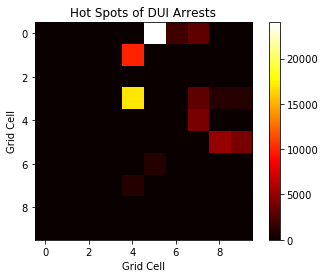

In [22]:
# HEATMAPPING ARRESTS
arrest_matrix= [[0 for j in range(matrix_dim)] for i in range(matrix_dim)]
for i in range(matrix_dim):
    for j in range(matrix_dim):
        in_list = matrix[i][j]
        population = in_list[3]
        if population == 0:
            #cannot divide by 0
            population = .001
        arrest_matrix[i][j] = in_list[1]/population

plt.imshow(arrest_matrix, cmap='hot', interpolation='nearest')
p = plt.colorbar()
plt.title('Hot Spots of DUI Arrests')
plt.xlabel('Grid Cell')
plt.ylabel('Grid Cell')
plt.show()

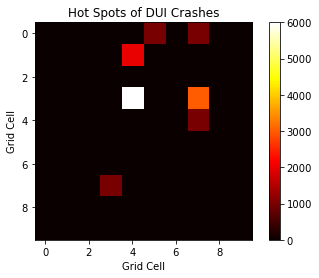

In [23]:
# HEATMAPPING Crashes
crash_matrix= [[0 for j in range(matrix_dim)] for i in range(matrix_dim)]
for i in range(matrix_dim):
    for j in range(matrix_dim):
        in_list = matrix[i][j]
        population = in_list[3]
        if population == 0:
            #cannot divide by 0
            population = .001
        crash_matrix[i][j] = in_list[0]/population

plt.imshow(crash_matrix, cmap='hot', interpolation='nearest')
p = plt.colorbar()
plt.title('Hot Spots of DUI Crashes')
plt.xlabel('Grid Cell')
plt.ylabel('Grid Cell')
plt.show()

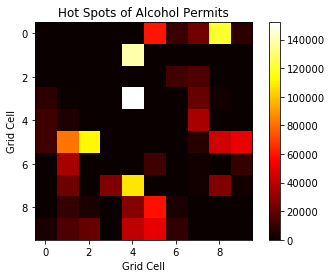

In [24]:
# HEATMAPPING Permits
permit_matrix= [[0 for j in range(matrix_dim)] for i in range(matrix_dim)]
for i in range(matrix_dim):
    for j in range(matrix_dim):
        in_list = matrix[i][j]
        population = in_list[3]
        if population == 0:
            #cannot divide by 0
            population = .001
        permit_matrix[i][j] = in_list[2]/population

plt.imshow(permit_matrix, cmap='hot', interpolation='nearest')
plt.title('Hot Spots of Alcohol Permits')
plt.xlabel('Grid Cell')
plt.ylabel('Grid Cell')
p = plt.colorbar()
plt.show()

# 2. Scatterplotting

Ratio of Crashes per Arrest:  0.130850866568


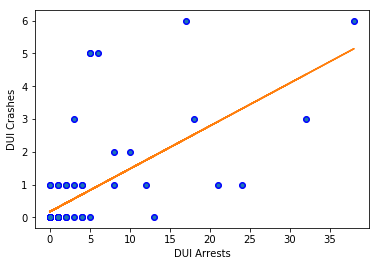

In [25]:
# ARREST v. CRASH SCATTERPLOT
import matplotlib.patches as mpatches

arrest_matrix_scatter= [[0 for j in range(matrix_dim)] for i in range(matrix_dim)]
for i in range(matrix_dim):
    for j in range(matrix_dim):
        in_list = matrix[i][j]
        arrest_matrix_scatter[i][j] = in_list[1]

crash_matrix_scatter= [[0 for j in range(matrix_dim)] for i in range(matrix_dim)]
for i in range(matrix_dim):
    for j in range(matrix_dim):
        in_list = matrix[i][j]
        crash_matrix_scatter[i][j] = in_list[0]


AF = np.array(arrest_matrix_scatter).flatten()
CF = np.array(crash_matrix_scatter).flatten()

plt.scatter(AF[:],CF[:], c='blue')
# Set our axis data
x = AF
y = CF

# Fit to a line with polyfit
m, b = np.polyfit(x, y, 1)

plt.plot(x, y, '.')
plt.plot(x, m*x + b, '-')
print("Ratio of Crashes per Arrest: ", m)
plt.xlabel('DUI Arrests')
plt.ylabel('DUI Crashes')
plt.show()

Ratio of Permits per Arrest:  2.83242506484


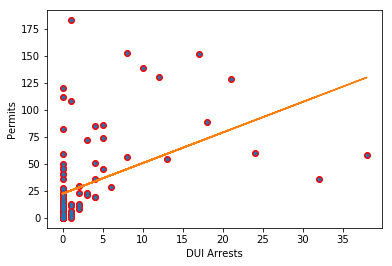

In [26]:
# ARREST v. PERMIT SCATTERPLOT

permit_matrix_scatter= [[0 for j in range(matrix_dim)] for i in range(matrix_dim)]
for i in range(matrix_dim):
    for j in range(matrix_dim):
        in_list = matrix[i][j]
        permit_matrix_scatter[i][j] = in_list[2]

PF = np.array(permit_matrix_scatter).flatten()

plt.scatter(AF[:],PF[:], c='red')
# Set our axis values
x = AF
y = PF

# Fit to a line with polyfit
m, b = np.polyfit(x, y, 1)

plt.plot(x, y, '.')
plt.plot(x, m*x + b, '-')
plt.xlabel('DUI Arrests')
plt.ylabel('Permits')
print("Ratio of Permits per Arrest: ", m)

plt.show()

Ratio of Permits per Crash:  12.6996584986


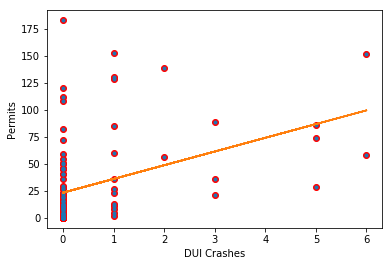

In [29]:
plt.scatter(CF[:],PF[:], c='red')
# Set our axis values
x = CF
y = PF

# Fit to a line with polyfit
m, b = np.polyfit(x, y, 1)

plt.plot(x, y, '.')
plt.plot(x, m*x + b, '-')
plt.xlabel('DUI Crashes')
plt.ylabel('Permits')
print("Ratio of Permits per Crash: ", m)

plt.show()

What does our 'grid' of San Diego look like?
-----

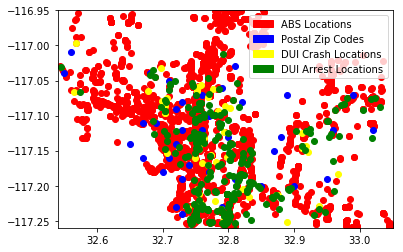

In [35]:
# Plot all 4 of our datasets in our grid of San Diego

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_xlim(32.54,33.05)
ax1.set_ylim(-117.26,-116.95 )

#Zip coordinates
zip_coordinates = np.zeros(len(df_zip_coords), dtype=('2float'))

for i in range(0,len(merged_zips)):
    zip_lat = float(merged_zips.iloc[i]['Lat'])
    zip_lng = float(merged_zips.iloc[i]['Lon']) 
    zip_coordinates[i] = (zip_lat,zip_lng)
    
#Alcohol Permits SCATTER PLOTTING

coords = np.zeros(len(alc_permits), dtype=('2float'))

for i in range(0, len(alc_permits)):
    alc_lat = float(alc_permits['lat'].iloc[i])
    alc_lng = float(alc_permits['lon'].iloc[i])
    coords[i] = (alc_lat, alc_lng)
        
coords = coords[0:len(coords)-2]
ax1.scatter(coords[:,0], coords[:,1], c='red')
ax1.scatter(zip_coordinates[:,0],zip_coordinates[:,1], c='blue')
ax1.scatter(crash_coords_arr[:,0],crash_coords_arr[:,1], c='yellow')
ax1.scatter(arrest_coords_arr[:,0],arrest_coords_arr[:,1],c='green')

#create legend
red_dots = mpatches.Patch(color='red',label='ABS Locations')
blue_dots = mpatches.Patch(color='blue',label='Postal Zip Codes')
yellow_dots = mpatches.Patch(color='yellow',label='DUI Crash Locations')
green_dots = mpatches.Patch(color='green',label='DUI Arrest Locations')

plt.legend(handles=[red_dots,blue_dots,yellow_dots,green_dots])

# Turn on the grid
plt.show()



# 3. OLS Modeling

In [27]:
import patsy
import statsmodels.api as sm

In [28]:
# Regression 1: Permits vs. Arrests
x = PF
y = AF

# Take the arrays uses for crash and arrest data, and create an OLS model.
arrest_permits = pd.DataFrame({'x': x, 'y':y})

# Let Arrests be our dependent value, based on number of Permits.
outcome, predictors = patsy.dmatrices('y ~ x', arrest_permits)

mod = sm.OLS(outcome,predictors)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     24.55
Date:                Mon, 12 Jun 2017   Prob (F-statistic):           3.03e-06
Time:                        18:22:29   Log-Likelihood:                -317.03
No. Observations:                 100   AIC:                             638.1
Df Residuals:                      98   BIC:                             643.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.5810      0.724      0.803      0.4

OLS Results: How well do permit counts predict arrest counts?
-------------------
Since our p-value obtained is very small (reads as 0.000) for the x column which represents permit counts, we can say with confidence that our coefficient of 0.0707 is statistically significant and close to the true value of arrests per permit. Thus, we can approximate that there are roughly 7 arrests for every 100 alcohol permits in San Diego.

In [29]:
# Regression 2: Permits vs. Crashes

# Assign x column to 'CF' (Crash data), y column to 'PF' (Permit data)
x = PF
y = CF
# Take the arrays uses for crash and arrest data, and create an OLS model.
crash_permits = pd.DataFrame({'x': x, 'y':y})
outcome, predictors = patsy.dmatrices('y ~ x', crash_permits)

mod = sm.OLS(outcome,predictors)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     18.93
Date:                Mon, 12 Jun 2017   Prob (F-statistic):           3.33e-05
Time:                        18:22:31   Log-Likelihood:                -158.68
No. Observations:                 100   AIC:                             321.4
Df Residuals:                      98   BIC:                             326.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.1463      0.148      0.985      0.3

OLS Results: How well do permit counts predict crash counts?
------------------------
Since the results above show a very small p value (reads 0.000 for the y column, represented by Permit Count data, we see that our coefficient is statistically significant and we can believe with confidence that there are roughly 127 car crashes for every 10,000 alcohol permits in San Diego.

In [52]:
# Sort matrix cells by population, create a histogram that shows what the distribution
# of arrests/crashes is. 

from operator import itemgetter
pop_arrests = {}
pop_crashes = {}
for i in range(0, len(matrix)-1):
    for j in range(0, len(matrix)-1):
        population = ((matrix[i])[j])[3]
        arrests = ((matrix[i])[j])[1]
        crashes = ((matrix[i])[j])[0]
        # add key-value pairs of population and arrest to a dictionary.
        pop_arrests[population] = arrests
        pop_crashes[population] = crashes
        
print("Pop_arrests dictionary: ", '\n\n', pop_arrests, '\n\n', 
      "Pop_crashes dictionary: ", '\n\n', pop_crashes)
#sorted(matrix[1], key=itemgetter(3))

Pop_arrests dictionary:  

 {0: 0, 12194.0: 4, 11450.5: 38, 858.75: 0, 12654.25: 32, 10845.5: 8, 1063.25: 0, 12429.0: 1, 283.75: 0, 19064.5: 1, 5963.0: 5, 24621.75: 13, 4544.0: 0, 8944.5: 8, 18553.25: 12, 18259.75: 0, 15689.75: 2, 11236.75: 3, 12407.5: 21, 6585.75: 2, 18259.25: 0, 12802.0: 4, 28309.25: 6, 4547.75: 18, 7583.0: 2, 7329.5: 1, 8770.5: 1, 16358.25: 4, 21224.75: 5, 8581.5: 0, 11848.25: 0, 27137.75: 1, 5759.75: 0, 19808.25: 0} 

 Pop_crashes dictionary:  

 {0: 0, 12194.0: 1, 11450.5: 6, 858.75: 0, 12654.25: 3, 10845.5: 2, 1063.25: 0, 12429.0: 1, 283.75: 0, 19064.5: 0, 5963.0: 5, 24621.75: 0, 4544.0: 0, 8944.5: 1, 18553.25: 1, 18259.75: 0, 15689.75: 0, 11236.75: 0, 12407.5: 1, 6585.75: 0, 18259.25: 0, 12802.0: 0, 28309.25: 5, 4547.75: 3, 7583.0: 1, 7329.5: 1, 8770.5: 0, 16358.25: 0, 21224.75: 5, 8581.5: 0, 11848.25: 0, 27137.75: 0, 5759.75: 0, 19808.25: 1}


In [31]:
import operator
sorted_x = sorted(pop_arrests.items(), key=operator.itemgetter(0))

y = np.zeros(len(sorted_x))
x = np.zeros(len(sorted_x))

for i in range(0, len(sorted_x)):
    y[i] = int(sorted_x[i][1])
    x[i] = int(sorted_x[i][0])
x
y

array([  0.,   0.,   0.,   0.,   0.,  18.,   0.,   5.,   2.,   1.,   2.,
         0.,   1.,   8.,   8.,   3.,  38.,   0.,   4.,  21.,   1.,  32.,
         4.,   2.,   4.,   0.,   0.,  12.,   1.,   0.,   5.,  13.,   1.,
         6.])

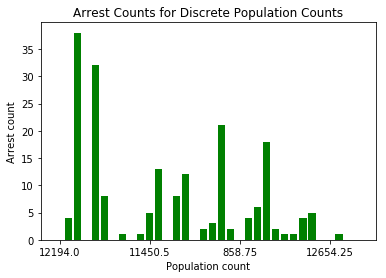

In [34]:
# Plot bar chart
import matplotlib.ticker as ticker
import math
ax = plt.subplot()

plt.bar(range(len(pop_arrests)), pop_arrests.values(),align='center', color='g')

plt.xticks(range(len(pop_arrests)), pop_arrests.keys())
plt.xlabel('Population count')
plt.ylabel('Arrest count')
plt.title('Arrest Counts for Discrete Population Counts')


tick_spacing = 10
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.show()


NOTE: The green barchart has dictionary keys plotted, which are unordered. Let's order them below and replot to see our distribution as population counts are listed from least to greatest.

Ordered list of population x-axis indices:  

[     0.      283.75    858.75   1063.25   4544.     4547.75   5759.75
   5963.     6585.75   7329.5    7583.     8581.5    8770.5    8944.5
  10845.5   11236.75  11450.5   11848.25  12194.    12407.5   12429.
  12654.25  12802.    15689.75  16358.25  18259.25  18259.75  18553.25
  19064.5   19808.25  21224.75  24621.75  27137.75  28309.25] 

Corresponding arrest count y-axis values:  

[ 0  0  0  0  0 18  0  5  2  1  2  0  1  8  8  3 38  0  4 21  1 32  4  2  4
  0  0 12  1  0  5 13  1  6]


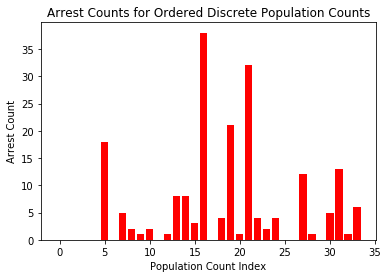

In [43]:
# Looking at the data in the previous bar chart, we see that the dictionary keys are unordered.
# Let's sort them and replot our bar chart.

lists = sorted(pop_arrests.items()) # sorted by key, return a list of tuples

x, y = zip(*lists)
x1 = np.array(x)
print("Ordered list of population x-axis indices: ", '\n')
print(x1, '\n')
print("Corresponding arrest count y-axis values: ", '\n')
y1 = np.array(y)
print(y1)
range_x1 = range(len(x1))
plt.xlabel('Population Count Index')
plt.ylabel('Arrest Count')
plt.title('Arrest Counts for Ordered Discrete Population Counts')
plt.bar(range_x1, y1, color = 'r')
plt.show()

NOTE: 
Unfortunately, in the above bar chart I could not figure out how to replace the 0 through 35 x-axis range with the actual population counts they correspond to. However, it must be noted that the ith index of the 'Ordered list of population x-axis indices' array printed above corresponds to the i label on the bar chart.
For example, index 5, the first bar in the chart corresponds to the 6th element of the array, which has a population of 4547.75 giving 18 arrests.
The data should be read as such.

Ordered list of population x-axis indices:  

[     0.      283.75    858.75   1063.25   4544.     4547.75   5759.75
   5963.     6585.75   7329.5    7583.     8581.5    8770.5    8944.5
  10845.5   11236.75  11450.5   11848.25  12194.    12407.5   12429.
  12654.25  12802.    15689.75  16358.25  18259.25  18259.75  18553.25
  19064.5   19808.25  21224.75  24621.75  27137.75  28309.25] 

Corresponding arrest count y-axis values:  

[0 0 0 0 0 3 0 5 0 1 1 0 0 1 2 0 6 0 1 1 1 3 0 0 0 0 0 1 0 1 5 0 0 5]


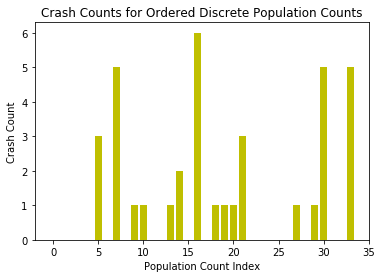

In [55]:
# Similarly, let's make an ordered bar chart displaying the occurrences of DUI crashes as
# population counts increase from left to right.

lists = sorted(pop_crashes.items()) # sorted by key, return a list of tuples

x, y = zip(*lists)
x1 = np.array(x)
print("Ordered list of population x-axis indices: ", '\n')
print(x1, '\n')
print("Corresponding arrest count y-axis values: ", '\n')
y1 = np.array(y)
print(y1)
range_x1 = range(len(x1))
plt.xlabel('Population Count Index')
plt.ylabel('Crash Count')
plt.title('Crash Counts for Ordered Discrete Population Counts')
plt.bar(range_x1, y1, color = 'y')
plt.show()

# Analysis and Results

Heatmap Results
----

Our heatmapping for both Crashes and Alcohol Permits shows the highest count of both variables to be in Gaslamp Quarter in downtown San Diego.

Our heatmapping result for Arrests shows the highest occurrence of arrests to be in Pacific Beach, another neighborhood well-reputed for drinking.

Scatterplotting/Line of Best Fit Results
----

Plot 1: Ratio of Crashes vs. Arrests
------
Our data does not appear to be very linear, so using a line of best fit may not accurately depict the relationship between crashes and arrests. This is elucidated further in our bar chart analysis, since it does not appear that the ratio of crashes to arrests stays consistent as population increases.

Plot 2: Ratio of Permits vs. Arrests
------
Our data again does not appear to be very linear, so using a line of best fit may not accurately depict the relationship between permits and arrests. However, this data is more densely clustered around smaller numbers of permits and smaller numbers of arrests, so this subset of the data may more accurately be represented by the ratio value obtained of 2.8 permits per arrest.

OLS Result 1: How well do permit counts predict crash counts?
------------------------
Since the results above show a very small p value (reads 0.000 for the y column, represented by Permit Count data, we see that our coefficient is statistically significant. However, our R squared value is rather small (0.16), so we can only confidently say that about 16% of the variation in our dependent variable (Crash counts) is predicted by permit counts.

If we interpret 16% of the variation to be accurate, this indicates that there are roughly 127 car crashes for every 10,000 alcohol permits in San Diego.

OLS Result 2: How well do permit counts predict arrest counts?
-------------------
Since our p-value obtained is very small (reads as 0.000) for the x column which represents permit counts, we see that our correlation is statistically significant. However, our R squared value is rather small (0.19), which means only about 19% of the variance in our dependent variable (arrest counts) is actually predicted accurately by our permit counts. Our coefficient of 0.0707 is statistically significant based on our small p-value, and if we only account for 19% of our data, we can approximate that there are roughly 7 arrests for every 100 alcohol permits in San Diego.

Bar Chart Analysis
------

Red Chart: Arrest Counts vs. Increasing Population Counts
----
In the ordered bar chart we created comparing arrest counts to population counts, our data appears to be almost normally distributed. We guessed that higher density areas would have greater instances of arrests, but it turns out that this is not necessarily true. 
One possible explanation could be that higher density areas would correspond to downtown locations where businesses and drinking destinations are more densely packed, thus limiting the need to travel by car and preventing DUI's.

This result could be biased as it may be more convenient for police officers to be posted in less dense areas, which is why arrest counts are higher.

Yellow Chart: Crash Counts vs. Increasing Population Counts
---
In this ordered bar chart, we see that crash data is more uniformly distributed across diverse population counts, with a less defined peak in the middle than the red chart displaying arrest counts. Furthermore, in our data, crash counts do not exceed 6 in our 180 day timeframe while they peak at 32 for arrests.

# Conclusion

Our results show that the number of crashes compared to the number of arrests in a given grid square of San Diego is not at all a 1-1 ratio, disproving our initial hypothesis. There are significantly more arrests per capita compared to the number of crashes. The proportion returned by our line of best fit was 0.13, indicating roughly 13 crashes for every 100 arrests. 

From our analysis, we cannot say with confidence that the number of permits are accurate predictors of all arrests and crashes in a given San Diego location. The R squared values of our OLS regression tests were 20% or below, meaning only 20% of the variation in either arrests or crashes could be accurately predicted by the number of permits. 

What was most notable was our bar chart results, which showed the number of crashes across both low and high population counts remained somewhat consistent, while arrest counts peaked in mid-range population areas and lowered in low-density and high-density population areas. This could be a call to action for more DUI checkpoint stops in low and high population density locations.